In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

In [10]:
df = pd.read_csv('Top Anime Dataset 2024.csv')

# Data Overview

In [11]:
df.head()

,Unnamed: 0,Score,Popularity,Rank,Members,Description,Synonyms,Japanese,English,Type,...,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Demographic,Duration,Rating
0,0,9.38,284,1,710,During their decade-long quest to defeat the D...,Frieren at the Funeral,葬送のフリーレン,Frieren: Beyond Journey's End,TV,...,Fall 2023,Fridays at 23:00 (JST),"Aniplex, Dentsu, Shogakukan-Shueisha Productio...","None found, add some",Madhouse,Manga,"AdventureAdventure, DramaDrama, FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,1,9.09,3,2,3,After a horrific alchemy experiment goes wrong...,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,Fullmetal Alchemist: Brotherhood,TV,...,Spring 2009,Sundays at 17:00 (JST),"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,"ActionAction, AdventureAdventure, DramaDrama, ...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,2,9.07,13,3,2,Eccentric scientist Rintarou Okabe has a never...,NaN,STEINS;GATE,Steins;Gate,TV,...,Spring 2011,Wednesdays at 02:05 (JST),"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation,White Fox,Visual novel,"DramaDrama, Sci-FiSci-Fi, SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older
3,3,9.06,342,4,630,"Gintoki, Shinpachi, and Kagura return as the f...",Gintama' (2015),銀魂°,Gintama Season 4,TV,...,Spring 2015,Wednesdays at 18:00 (JST),"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,"ActionAction, ComedyComedy, Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,4,9.05,21,5,2,Seeking to restore humanity's diminishing hope...,NaN,進撃の巨人 Season3 Part.2,Attack on Titan Season 3 Part 2,TV,...,Spring 2019,Mondays at 00:10 (JST),"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,Wit Studio,Manga,"ActionAction, DramaDrama, SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1000 non-null   int64  
 1   Score        1000 non-null   float64
 2   Popularity   1000 non-null   int64  
 3   Rank         1000 non-null   int64  
 4   Members      1000 non-null   int64  
 5   Description  1000 non-null   object 
 6   Synonyms     709 non-null    object 
 7   Japanese     999 non-null    object 
 8   English      859 non-null    object 
 9   Type         1000 non-null   object 
 10  Episodes     1000 non-null   object 
 11  Status       1000 non-null   object 
 12  Aired        1000 non-null   object 
 13  Premiered    569 non-null    object 
 14  Broadcast    569 non-null    object 
 15  Producers    1000 non-null   object 
 16  Licensors    1000 non-null   object 
 17  Studios      1000 non-null   object 
 18  Source       1000 non-null   object 
 19  Genres 

In [13]:
df.isnull().sum()

Unnamed: 0       0
Score            0
Popularity       0
Rank             0
Members          0
Description      0
Synonyms       291
Japanese         1
English        141
Type             0
Episodes         0
Status           0
Aired            0
Premiered      431
Broadcast      431
Producers        0
Licensors        0
Studios          0
Source           0
Genres         229
Demographic    479
Duration         0
Rating           0
dtype: int64

# Data Cleaning and Transformation

In [14]:
# Replace non-numeric values with NaN, then fill NaN with 0, and convert to int
df['Episodes'] = pd.to_numeric(df['Episodes'], errors='coerce').fillna(0).astype(int)

In [15]:
# Define a function to split 'Aired' into 'Start_Date' and 'End_Date'
def split_aired_dates(aired):
    if ' to ' in aired:
        start_date, end_date = aired.split(' to ')
        if end_date == '?':
            end_date = np.nan
    else:
        start_date, end_date = aired, np.nan
    return pd.Series([start_date, end_date])

# Apply the function and create 'Start_Date' and 'End_Date' columns
df[['Start_Date', 'End_Date']] = df['Aired'].apply(split_aired_dates)

# Replace 'Unknown' with 'NA'
df = df.replace('Unknown', 'NA')

# Convert 'Start_Date' and 'End_Date' to datetime and format to month/day/year
df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce').dt.strftime('%m/%d/%Y')
df['End_Date'] = pd.to_datetime(df['End_Date'], errors='coerce').dt.strftime('%m/%d/%Y')

In [16]:
# Define a function to split 'Premiered' into 'Premiered_Year' and 'Premiered_Season'
def split_premiered(premiered):
    try:
        if isinstance(premiered, str) and premiered.strip():  # Check if 'Premiered' is a non-empty string
            season, year = premiered.split(' ')
            return pd.Series([year, season])
        else:
            return pd.Series(['NA', 'NA'])
    except ValueError:
        return pd.Series(['NA', 'NA'])

# Apply the function and create 'Premiered_Year' and 'Premiered_Season' columns
df[['Premiered_Year', 'Premiered_Season']] = df['Premiered'].apply(split_premiered)

# Convert 'Premiered_Year' to datetime and format it to just the year
df['Premiered_Year'] = pd.to_datetime(df['Premiered_Year'], format='%Y', errors='coerce').dt.strftime('%Y')

In [17]:
# Function to split Broadcast into Broadcast_Day and Broadcast_Time (JST)
def split_broadcast(broadcast):
    if pd.isna(broadcast):  # Check for NaN values
        return pd.Series(['NA', 'NA'])
    elif ' at ' in broadcast:
        day, time = broadcast.split(' at ')
        if ' (JST)' in time:
            time = time.replace(' (JST)', '')
        return pd.Series([day, time])
    elif 'Unknown' in broadcast:
        return pd.Series(['NA', 'NA'])
    else:
        return pd.Series(['NA', 'NA'])

# Apply the function and create 'Broadcast_Day' and 'Broadcast_Time (JST)' columns
df[['Broadcast_Day', 'Broadcast_Time (JST)']] = df['Broadcast'].apply(split_broadcast)

# Convert 'Broadcast_Time (JST)' to time type
df['Broadcast_Time (JST)'] = pd.to_datetime(df['Broadcast_Time (JST)'], format='%H:%M', errors='coerce').dt.time

In [18]:
# Function to convert duration to minutes
def convert_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'hr.' in duration:
        hours_match = re.search(r'(\d+)\s*hr.', duration)
        if hours_match:
            hours = int(hours_match.group(1))
    if 'min.' in duration:
        minutes_match = re.search(r'(\d+)\s*min.', duration)
        if minutes_match:
            minutes = int(minutes_match.group(1))
    return hours * 60 + minutes

# Function to create Series_Duration and Movie_Duration columns
def split_duration(duration):
    if 'per ep.' in duration:
        series_duration = convert_to_minutes(duration)
        movie_duration = np.nan
    else:
        series_duration = np.nan
        movie_duration = convert_to_minutes(duration)
    return pd.Series([series_duration, movie_duration])

# Apply the function and create 'Series_Duration' and 'Movie_Duration' columns
df[['Series_Duration', 'Movie_Duration']] = df['Duration'].apply(split_duration)

# Convert the new columns to appropriate data types
df['Series_Duration'] = df['Series_Duration'].astype('Int64') 
df['Movie_Duration'] = df['Movie_Duration'].astype('Int64')

In [31]:
# Fill Missing Values
columns_to_fill_NA = ['Synonyms', 'Japanese', 'English', 'Premiered', 'Broadcast', 'Genres', 'Demographic']
df[columns_to_fill_NA] = df[columns_to_fill_NA].fillna('NA')

columns_to_fill_z = ['Premiered_Year', 'Premiered_Season', 'Episodes', 'Start_Date', 'End_Date', 
                     'Broadcast_Day', 'Broadcast_Time (JST)','Series_Duration','Movie_Duration']
df[columns_to_fill_z] = df[columns_to_fill_z].fillna(0)

In [20]:
df.to_csv('cleaned_data.csv')

# Data Visualization

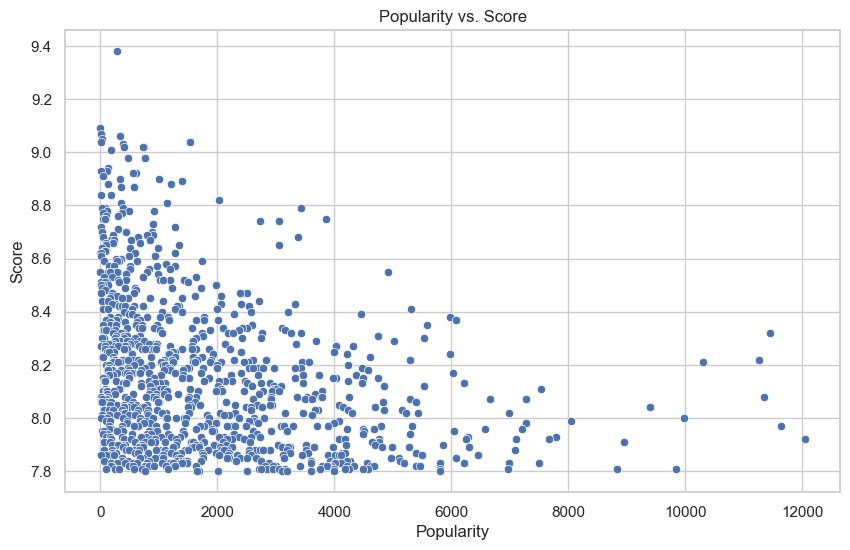

In [21]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Popularity vs. Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Popularity', y='Score', data=df)
plt.title('Popularity vs. Score')
plt.xlabel('Popularity')
plt.ylabel('Score')
plt.show()

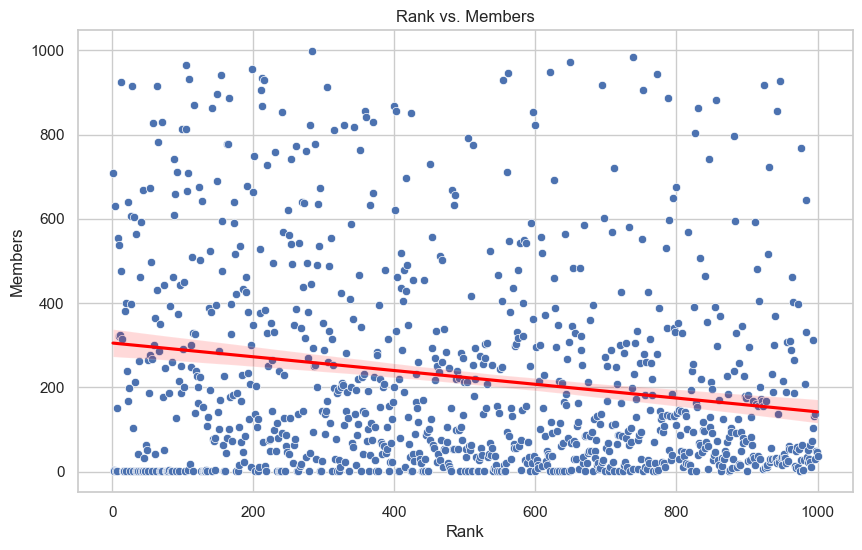

In [29]:
# Rank vs. Members
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rank', y='Members', data=df)
plt.title('Rank vs. Members')
plt.xlabel('Rank')
plt.ylabel('Members')
sns.regplot(x='Rank', y='Members', data=df, scatter=0, color='red')
plt.show()

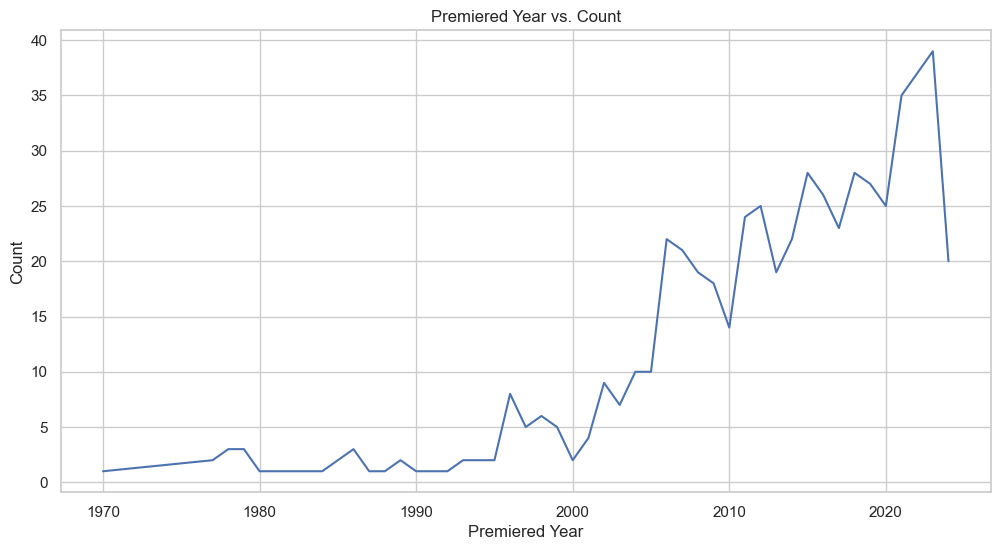

In [23]:
# Premiered Year vs. Count
df['Premiered_Year'] = pd.to_datetime(df['Premiered_Year'], format='%Y', errors='coerce').dt.year
premiered_year_count = df['Premiered_Year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=premiered_year_count.index, y=premiered_year_count.values)
plt.title('Premiered Year vs. Count')
plt.xlabel('Premiered Year')
plt.ylabel('Count')
plt.show()

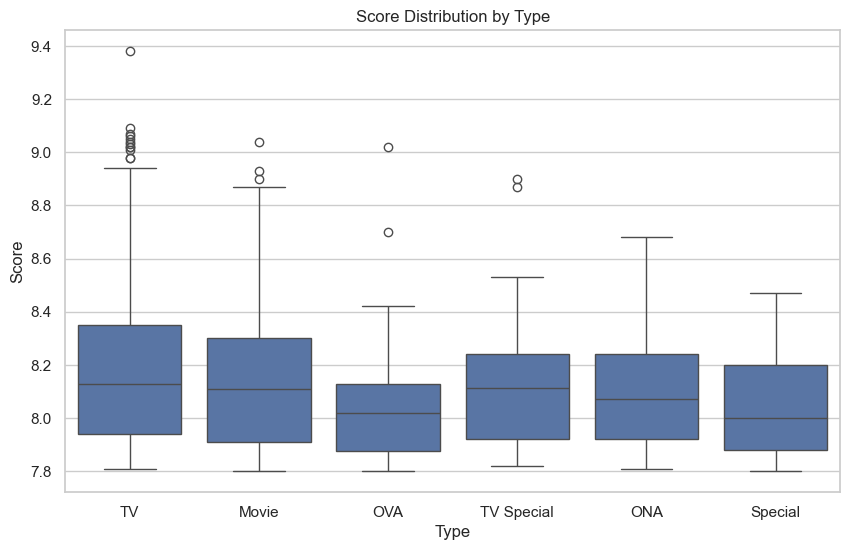

In [24]:
# Box plot of Score by Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Score', data=df)
plt.title('Score Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.show()

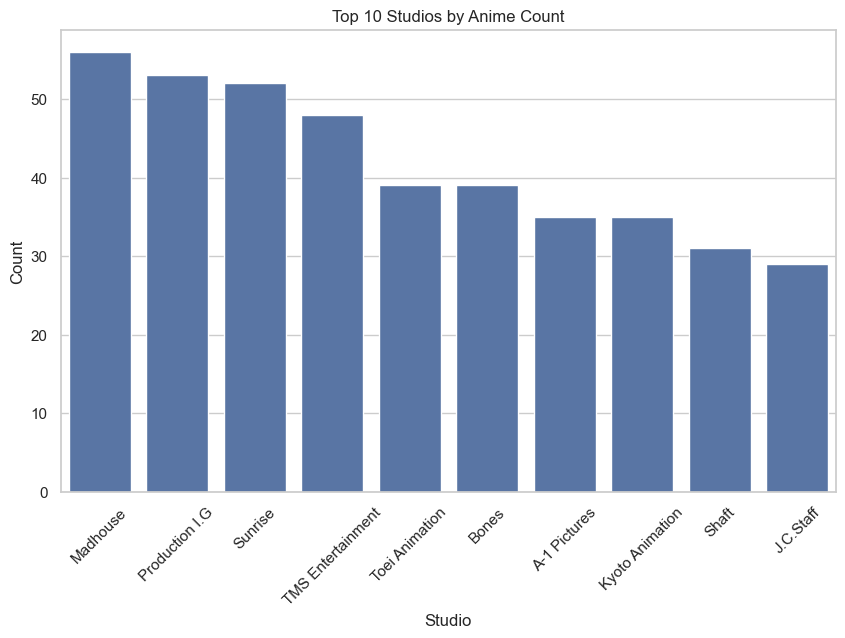

In [25]:
# Bar plot of top 10 Studios by anime count
studio_counts = df['Studios'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=studio_counts.index, y=studio_counts.values)
plt.title('Top 10 Studios by Anime Count')
plt.xlabel('Studio')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

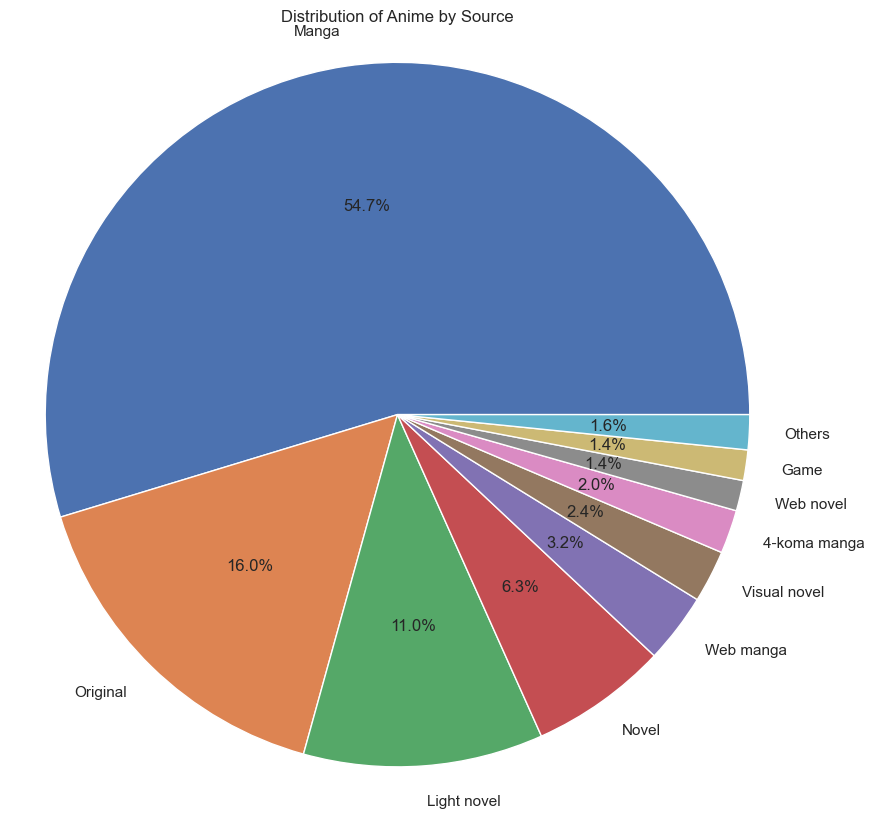

In [26]:
# Pie chart of Source distribution
source_counts = df['Source'].value_counts(normalize=True)
others = source_counts[source_counts < 0.01].sum()
source_counts = source_counts[source_counts >= 0.01]
source_counts = pd.concat([source_counts, pd.Series({'Others': others})])

plt.figure(figsize=(10, 10))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Anime by Source')
plt.axis('equal')
plt.show()

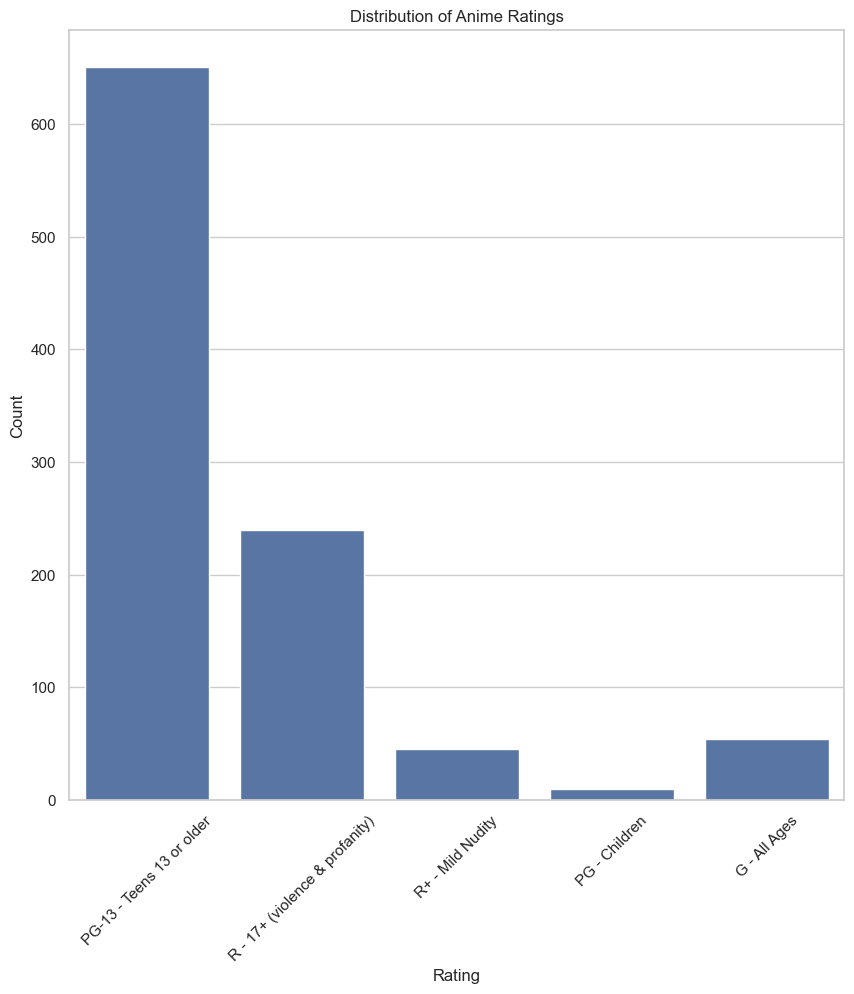

In [27]:
# Count plot of Rating
plt.figure(figsize=(10, 10))
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Anime Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()